In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from typing import List, Tuple
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from dataclasses import dataclass
import ipywidgets as widgets
from IPython.display import display, clear_output

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-data/Task 3 and 4_Loan_Data.csv


In [9]:
# Load data with proper date formatting
df = pd.read_csv('../input/loan-data/Task 3 and 4_Loan_Data.csv')

In [10]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [11]:
# Ensure correct parsing (adjust as needed based on actual data structure)
# For this example, focus on 'fico_score' and 'default'
df = df[['fico_score', 'default']]

In [12]:
# Sort data by FICO score
df_sorted = df.sort_values('fico_score').reset_index(drop=True)
scores = df_sorted['fico_score'].values
defaults = df_sorted['default'].values

In [13]:
# Precompute cumulative sums for efficient range queries
cum_defaults = np.cumsum(np.hstack([0, defaults]))
cum_counts = np.cumsum(np.hstack([0, np.ones_like(defaults)]))

In [14]:
def compute_log_likelihood(j, i):
    """Compute log-likelihood for data points from j to i (exclusive)"""
    ki = cum_defaults[i] - cum_defaults[j]
    ni = cum_counts[i] - cum_counts[j]
    if ni == 0:
        return -np.inf
    # Apply Laplace smoothing with alpha=1 to avoid log(0)
    alpha = 1  # Adds 1 "pseudo-default" and 1 "pseudo-non-default"
    pi = (ki + alpha) / (ni + 2 * alpha)
    return ki * np.log(pi) + (ni - ki) * np.log(1 - pi)


In [15]:
def optimal_bucketing(n_buckets):
    n = len(scores)
    dp = -np.inf * np.ones((n_buckets + 1, n + 1))
    dp[0, 0] = 0
    back = np.zeros((n_buckets + 1, n + 1), dtype=int)

    for k in range(1, n_buckets + 1):
        for i in range(1, n + 1):
            for j in range(i):
                current_ll = dp[k-1, j] + compute_log_likelihood(j, i)
                if current_ll > dp[k, i]:
                    dp[k, i] = current_ll
                    back[k, i] = j

    # Backtrack to find boundaries
    boundaries = []
    current = n
    for k in range(n_buckets, 0, -1):
        prev = back[k, current]
        boundaries.insert(0, scores[prev] if prev < len(scores) else scores[-1])
        current = prev

    # Remove duplicates and clean boundaries
    boundaries = sorted(list(set(boundaries)))
    return boundaries


In [16]:
# Example usage: Split into 5 buckets
n_buckets = 5
boundaries = optimal_bucketing(n_buckets)


In [17]:
# Generate bucket ranges
bucket_ranges = []
prev = 300  # Minimum FICO score
for boundary in boundaries[1:]:  # Skip the first (min)
    bucket_ranges.append((prev, boundary))
    prev = boundary
bucket_ranges.append((prev, 850))  # Add max FICO

print("Optimal Bucket Boundaries:")
for i, (low, high) in enumerate(bucket_ranges):
    print(f"Bucket {i+1}: {low} - {high}")

Optimal Bucket Boundaries:
Bucket 1: 300 - 521
Bucket 2: 521 - 580
Bucket 3: 580 - 640
Bucket 4: 640 - 696
Bucket 5: 696 - 850


In [18]:
# Calculate PD for each bucket
df['bucket'] = pd.cut(df['fico_score'], 
                       bins=[300] + boundaries + [850], 
                       labels=False, include_lowest=True)
pd_df = df.groupby('bucket').agg(
    total=('default', 'count'),
    defaults=('default', 'sum')
).reset_index()
pd_df['PD'] = pd_df['defaults'] / pd_df['total']
print("\nProbability of Default per Bucket:")
print(pd_df[['bucket', 'PD']])


Probability of Default per Bucket:
   bucket        PD
0       0  0.000000
1       1  0.653968
2       2  0.380029
3       3  0.204479
4       4  0.105099
5       5  0.046470


In [ ]:
# Optimize the bucket boundaries
optimal_boundaries = optimize_buckets(df['fico_score'], df['default'], num_buckets)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


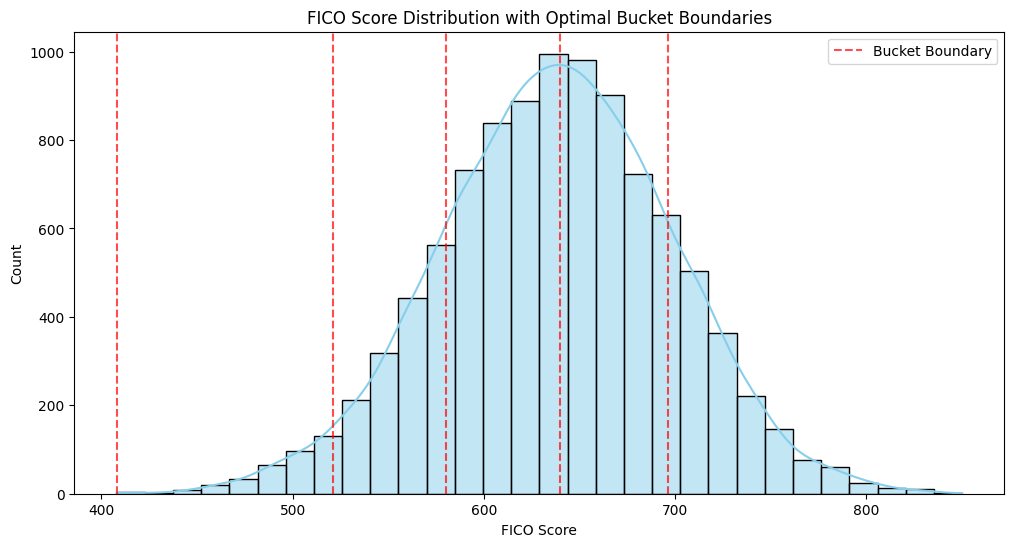

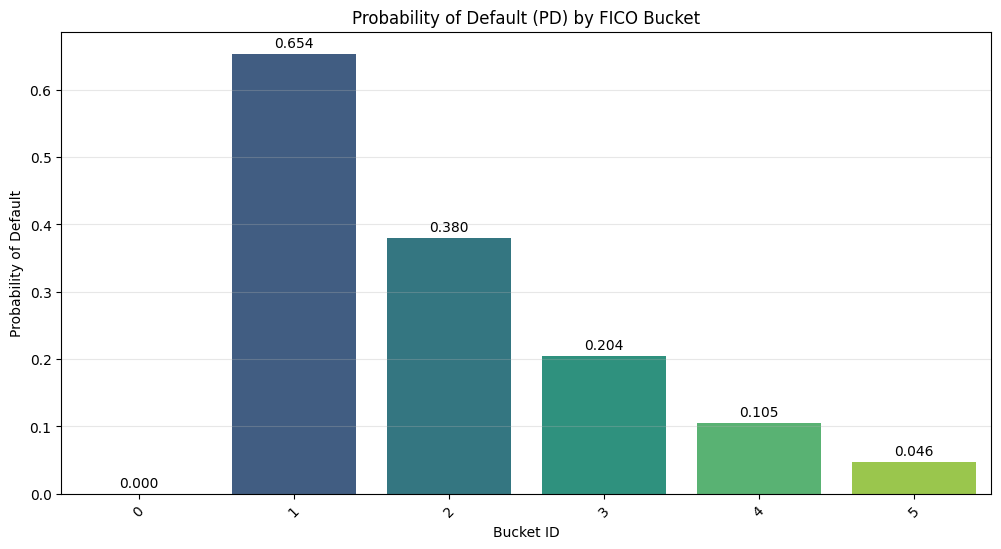

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


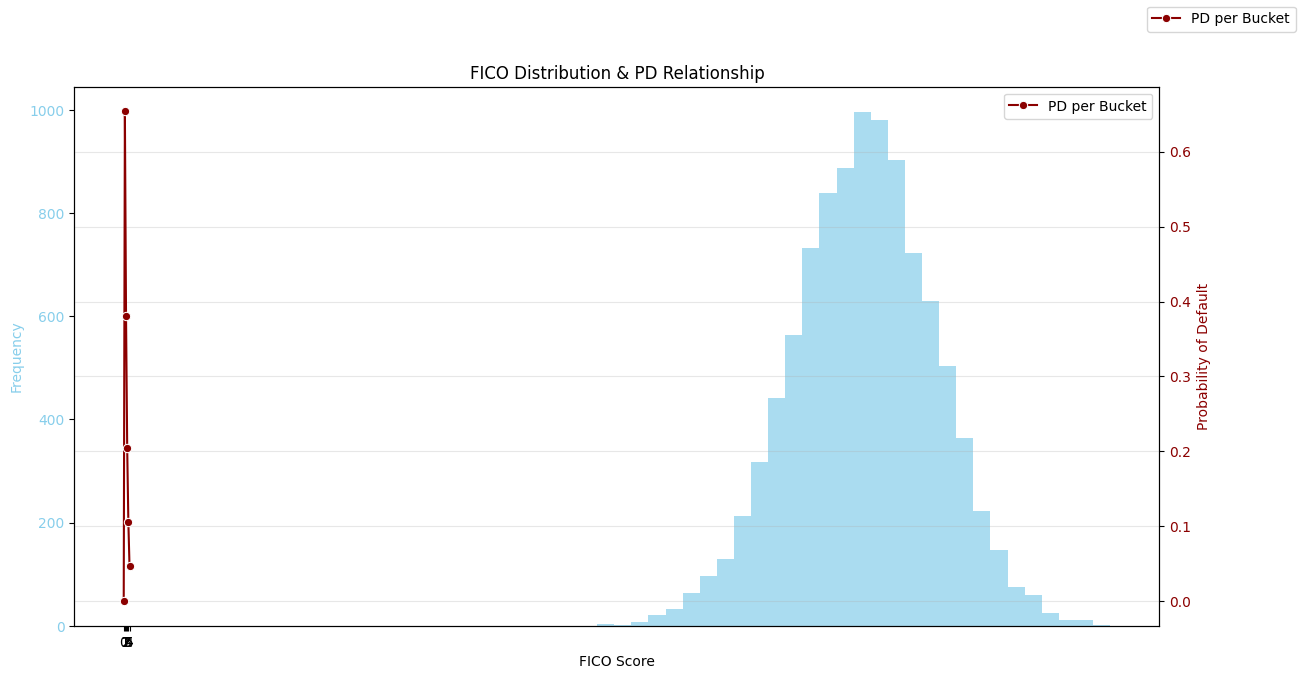

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ----------------------------------------------------------
# Plot 1: Distribution of FICO Scores with Bucket Boundaries
# ----------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df['fico_score'], bins=30, kde=True, color='skyblue')
plt.title('FICO Score Distribution with Optimal Bucket Boundaries')
plt.xlabel('FICO Score')
plt.ylabel('Count')

# Add vertical lines for bucket boundaries
for boundary in boundaries:
    plt.axvline(boundary, color='red', linestyle='--', alpha=0.7, label='Bucket Boundary' if boundary == boundaries[0] else "")

plt.legend()
plt.show()

# ----------------------------------------------------------
# Plot 2: Probability of Default (PD) per Bucket
# ----------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x='bucket', y='PD', data=pd_df, palette='viridis')
plt.title('Probability of Default (PD) by FICO Bucket')
plt.xlabel('Bucket ID')
plt.ylabel('Probability of Default')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add PD values as text labels
for index, row in pd_df.iterrows():
    plt.text(index, row.PD + 0.01, f'{row.PD:.3f}', ha='center')

plt.show()

# ----------------------------------------------------------
# Plot 3: Combined View (FICO Distribution + PD Curve)
# ----------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(14, 7))

# Histogram on primary axis
ax1.hist(df['fico_score'], bins=30, color='skyblue', alpha=0.7)
ax1.set_xlabel('FICO Score')
ax1.set_ylabel('Frequency', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# PD curve on secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    x=pd_df['bucket'].astype(str), 
    y=pd_df['PD'], 
    marker='o', 
    color='darkred', 
    ax=ax2,
    label='PD per Bucket'
)
ax2.set_ylabel('Probability of Default', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.grid(alpha=0.3)

plt.title('FICO Distribution & PD Relationship')
fig.legend(loc='upper right')
plt.show()

In [21]:
from ipywidgets import interact

@interact(n_buckets=(2, 10))
def update_buckets(n_buckets=5):
    boundaries = optimal_bucketing(n_buckets)
    df['bucket'] = pd.cut(df['fico_score'], bins=[300] + boundaries + [850])
    pd_df = df.groupby('bucket').agg(PD=('default', 'mean')).reset_index()
    
    plt.figure(figsize=(10, 4))
    sns.barplot(x='bucket', y='PD', data=pd_df, palette='coolwarm')
    plt.title(f'PD with {n_buckets} Buckets')
    plt.xticks(rotation=45)
    plt.show()

interactive(children=(IntSlider(value=5, description='n_buckets', max=10, min=2), Output()), _dom_classes=('wi…